# LLM Factor Analysis - Scale Items (Qwen3-Embedding Models)

Extracts embeddings from scale items using **Qwen3-Embedding models** and compares predicted similarities with observed correlations.

**Available Models:**
- Qwen3-Embedding-0.6B (600M parameters, ~2.4 GB, 1024D)
- Qwen3-Embedding-4B (4B parameters, ~16 GB, 4096D) 
- Qwen3-Embedding-8B (8B parameters, ~32 GB, 8192D)

**Model Configuration:**
- Precision: FP32 (full precision)
- Library: sentence-transformers (simplified API)
- Supports: 100+ languages, MTEB top-ranked performance

**Getting Started:**
- **All user settings** are in the **Configuration** section below (model selection, pre-generated embeddings, custom words)
- Easily enable/disable models by commenting/uncommenting lines in `model_names`
- Use pre-generated embeddings for faster runs (see Configuration section)

## Import Dependencies

This notebook requires:
- `sentence-transformers>=2.7.0`
- `transformers>=4.51.0`
- `torch>=2.0.0`

In [40]:
import os
import sys
from datetime import datetime

import pandas as pd
import numpy as np
print("  - pandas and numpy loaded")

os.chdir('/home/devon7y/scratch/devon7y/llm')
os.getcwd()

import torch
print(f"  - torch {torch.__version__} loaded")

# Check if sentence-transformers is installed
try:
    from sentence_transformers import SentenceTransformer
    import sentence_transformers
    print(f"  - sentence-transformers {sentence_transformers.__version__} loaded")
except ImportError:
    print("\nERROR: sentence-transformers not found!")
    print("Please install: pip install sentence-transformers>=2.7.0")
    raise

# Check transformers version
import transformers
print(f"  - transformers {transformers.__version__} loaded")

  - pandas and numpy loaded
  - torch 2.7.1 loaded
  - sentence-transformers 5.1.1 loaded
  - transformers 4.57.1 loaded


## Configuration - User Settings

**Edit these variables to customize your analysis:**

All user-changeable settings are collected here for easy access.

In [41]:
# ============================================================================
# MODEL SELECTION - Comment out any models you don't want to run
# ============================================================================
# To disable a model, add a '#' at the start of its line
# To enable a model, remove the '#' from the start of its line
# ============================================================================

model_names = [
    #Qwen/Qwen3-Embedding-0.6B",     # 600M parameters, ~2.4 GB, 1024D
    "Qwen/Qwen3-Embedding-4B",      # 4B parameters, ~16 GB, 4096D
    #"Qwen/Qwen3-Embedding-8B"       # 8B parameters, ~32 GB, 8192D
]

# ============================================================================
# PRE-GENERATED EMBEDDINGS - Optional paths to pre-generated embedding files
# ============================================================================
# Specify paths for each model size. Use empty string ("") or None to generate on-the-fly.
# Run 'python generate_word_embeddings.py' first to create these files.
# Default location: embeddings/wordfreq_top60000_with_constructs_{model_size}.npz
# ============================================================================

word_list_path = "word_lists/constructs.csv"

PREGENERATED_EMBEDDINGS = {
    #"0.6B": "embeddings/wordfreq_top60000_with_constructs_0.6B.npz",
    "4B": "embeddings/constructs_4B.npz",
    #"8B": "embeddings/wordfreq_top60000_with_constructs_8B.npz",
}

# ============================================================================
# PCA COMPONENT ANALYSIS SETTINGS
# ============================================================================
# Number of PCA components to extract (None = use parallel analysis to auto-determine)
N_PCA_COMPONENTS = 3

# Use Varimax rotation for improved interpretability (recommended)
USE_VARIMAX_ROTATION = True

# ============================================================================
# CUSTOM WORDS - For testing specific words against component centroids
# ============================================================================
# Option 1: Manually specify words (uncomment and add words below)
custom_words = [
    # Add your words here, one per line
    # Example: "happiness", "sadness", "anger"
]

# Option 2: Load from constructs.csv (uncomment to use)
# import pandas as pd
# constructs_df = pd.read_csv("word_lists/constructs.csv")
# custom_words = constructs_df['word'].tolist()

# Option 3: Select specific constructs from the file (uncomment to use)
# import pandas as pd
# constructs_df = pd.read_csv("word_lists/constructs.csv")
# custom_words = constructs_df['word'].tolist()[:50]  # First 50 constructs

# ============================================================================

print("Configuration loaded successfully!")
print("=" * 70)
print(f"Selected models: {[m.split('/')[-1] for m in model_names]}")
print(f"PCA components: {N_PCA_COMPONENTS if N_PCA_COMPONENTS else 'Auto (parallel analysis)'}")
print(f"Varimax rotation: {USE_VARIMAX_ROTATION}")
print(f"Custom words specified: {len(custom_words)}")
print("=" * 70)

Configuration loaded successfully!
Selected models: ['Qwen3-Embedding-4B']
PCA components: 3
Varimax rotation: True
Custom words specified: 0


## Load and Process Data

In [42]:
print("Loading scale...")
scale = pd.read_csv('scales/DASS_items.csv', usecols=['code', 'item', 'factor'])
print(f"Loaded {len(scale)} items")

# Preview the data
scale.head()

Loading scale...
Loaded 42 items


,code,item,factor
0,S1,I found myself getting upset by quite trivial ...,Stress
1,A2,I was aware of dryness of my mouth.,Anxiety
2,D3,I couldn't seem to experience any positive fee...,Depression
3,A4,"I experienced breathing difficulty (eg, excess...",Anxiety
4,D5,I just couldn't seem to get going.,Depression


In [43]:
# Extract codes, items and factors for easier access
codes = scale['code'].tolist()
items = scale['item'].tolist()
factors = scale['factor'].tolist()

print(f"Total items: {len(items)}")
print(f"Unique factors: {sorted(set(factors))}")
print(f"Sample codes: {codes[:5]}")

Total items: 42
Unique factors: ['Anxiety', 'Depression', 'Stress']
Sample codes: ['S1', 'A2', 'D3', 'A4', 'D5']


## Device Detection and Memory Check

In [44]:
# Detect available device(s)
print("Detecting available device(s)...")

# Check for CUDA GPUs
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    device = torch.device('cuda')
    print(f"✓ Found {num_gpus} CUDA GPU(s):")
    for i in range(num_gpus):
        print(f"    GPU {i}: {torch.cuda.get_device_name(i)}")
    
    if num_gpus > 1:
        print(f"\n✓ Multi-GPU mode enabled - will use {num_gpus} GPUs for parallel processing")
        use_multi_gpu = True
    else:
        print(f"\n✓ Using single GPU: {torch.cuda.get_device_name(0)}")
        use_multi_gpu = False

# Check for Apple MPS
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    num_gpus = 1
    use_multi_gpu = False
    print("✓ Using Apple MPS GPU (Metal Performance Shaders)")

# Fallback to CPU
else:
    device = torch.device('cpu')
    num_gpus = 0
    use_multi_gpu = False
    print("✓ Using CPU")

# Check available memory
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"\nSystem Memory:")
    print(f"  Total: {mem.total / (1024**3):.1f} GB")
    print(f"  Available: {mem.available / (1024**3):.1f} GB")
    print(f"  Used: {mem.percent}%")
except ImportError:
    print("\n  psutil not installed - skipping memory check")
    print("Install with: pip install psutil")

Detecting available device(s)...
✓ Using CPU

System Memory:
  Total: 755.4 GB
  Available: 698.1 GB
  Used: 7.6%


## Load Qwen3-Embedding Models

**Memory Requirements (FP32 full precision):**
- Qwen3-Embedding-0.6B: ~2.4 GB, 1024D embeddings
- Qwen3-Embedding-4B: ~16 GB, 4096D embeddings
- Qwen3-Embedding-8B: ~32 GB, 8192D embeddings

**Model Selection:** Edit the `model_names` list in the **Configuration** cell at the top of this notebook to choose which models to load.

In [45]:
# Dictionary to store results
all_embeddings = {}
all_models = {}
all_pools = {}  # Store multi-GPU pools

print(f"Loading {len(model_names)} Qwen3-Embedding model(s)...")
print("=" * 70)
print(f"Selected models: {[m.split('/')[-1] for m in model_names]}")
print("=" * 70)

for model_name in model_names:
    model_size = model_name.split("-")[-1]
    print(f"\n{'='*70}")
    print(f"Loading {model_name}")
    print(f"{'='*70}")
    print(f"This may take 30-120 seconds depending on model size...")
    
    try:
        # Load model - let sentence-transformers handle device placement automatically
        model = SentenceTransformer(model_name)
        
        print(f"✓ {model_size} model loaded successfully!")
        print(f"  Device: {model.device}")
        print(f"  Max sequence length: {model.max_seq_length}")
        
        # Check embedding dimension
        test_embedding = model.encode(["test"], convert_to_numpy=True)
        print(f"  Embedding dimension: {test_embedding.shape[1]}")
        
        # Set up multi-GPU processing if available
        pool = None
        if use_multi_gpu and torch.cuda.is_available() and num_gpus > 1:
            try:
                print(f"\n  Setting up multi-GPU processing pool...")
                print(f"  Distributing model across {num_gpus} GPUs...")
                
                # Start multi-process pool for parallel GPU processing
                pool = model.start_multi_process_pool()
                
                print(f"  ✓ Multi-GPU pool created successfully!")
                print(f"    Will use {num_gpus} GPUs for parallel batch processing")
                
            except Exception as pool_error:
                print(f"  ⚠ Warning: Could not create multi-GPU pool:")
                print(f"    {type(pool_error).__name__}: {str(pool_error)}")
                print(f"    Falling back to single-GPU mode")
                pool = None
        
        # Store the model and pool
        all_models[model_size] = model
        all_pools[model_size] = pool
        
    except Exception as e:
        print(f"\nError loading {model_name}:")
        print(f"  {type(e).__name__}: {str(e)}")
        print(f"  Skipping this model and continuing with others...")
        continue

print(f"\n{'='*70}")
print(f"✓ Successfully loaded {len(all_models)} model(s)!")
if any(all_pools.values()):
    num_multi_gpu = sum(1 for p in all_pools.values() if p is not None)
    print(f"✓ {num_multi_gpu} model(s) configured for multi-GPU processing")
print(f"{'='*70}")

Loading 1 Qwen3-Embedding model(s)...
Selected models: ['Qwen3-Embedding-4B']

Loading Qwen/Qwen3-Embedding-4B
This may take 30-120 seconds depending on model size...


Loading checkpoint shards: 100%|████████████████████████████████████| 2/2 [01:33<00:00, 46.55s/it]


✓ 4B model loaded successfully!
  Device: cpu
  Max sequence length: 40960
  Embedding dimension: 2560

✓ Successfully loaded 1 model(s)!


## Extract Embeddings for All Models

Using sentence-transformers' `encode()` method for each model.

**Processing:**
- Extract embeddings for all personality items with each model
- Using `batch_size=8` for efficient processing
- Results stored in `all_embeddings` dictionary keyed by model size

In [46]:
print(f"Extracting embeddings for {len(items)} personality items using all models...")
print("=" * 70)

for model_size, model in all_models.items():
    print(f"\n{'='*70}")
    print(f"Processing with {model_size} model")
    print(f"{'='*70}")
    
    # Check if multi-GPU pool is available for this model
    pool = all_pools.get(model_size, None)
    
    try:
        if pool is not None:
            # Multi-GPU processing
            print(f"Using multi-GPU processing across {num_gpus} GPUs...")
            embeddings = model.encode_multi_process(
                items,
                pool,
                batch_size=8,  # Batch size per GPU
                normalize_embeddings=False  # Keep raw embeddings for analysis
            )
        else:
            # Single GPU/MPS/CPU processing
            print(f"Using single-device processing...")
            embeddings = model.encode(
                items,
                batch_size=21,
                show_progress_bar=True,
                convert_to_numpy=True,
                normalize_embeddings=False  # Keep raw embeddings for analysis
            )
        
        # Store results
        all_embeddings[model_size] = embeddings
        
        print(f"\n✓ Embedding extraction complete for {model_size}!")
        print(f"  Shape: {embeddings.shape}")
        print(f"  ({embeddings.shape[0]} items × {embeddings.shape[1]} dimensions)")
        
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"\nOut of memory error with {model_size}!")
            print(f"  Try reducing batch_size or using a smaller model")
            raise
        else:
            raise

print(f"\n{'='*70}")
print(f"✓ All embeddings extracted successfully!")
print(f"{'='*70}")
print(f"\nEmbedding dimensions by model:")
for model_size, embeddings in all_embeddings.items():
    print(f"  {model_size}: {embeddings.shape[1]}D")

Extracting embeddings for 42 personality items using all models...

Processing with 4B model
Using single-device processing...


Batches: 100%|██████████████████████████████████████████████████████| 2/2 [00:37<00:00, 18.90s/it]


✓ Embedding extraction complete for 4B!
  Shape: (42, 2560)
  (42 items × 2560 dimensions)

✓ All embeddings extracted successfully!

Embedding dimensions by model:
  4B: 2560D


## Inspect Embedding Results

In [47]:
# Compare embedding dimensions across models
print("Embedding dimensions by model:")
print("=" * 70)
for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Shape: {embeddings.shape}")
    print(f"  Embedding dimension: {embeddings.shape[1]}D")
    print(f"  First embedding (first 10 values): {embeddings[0][:10]}")

Embedding dimensions by model:

4B:
  Shape: (42, 2560)
  Embedding dimension: 2560D
  First embedding (first 10 values): [-0.00023631  0.01915852  0.01500716 -0.03507183 -0.00114805  0.02597213
  0.06236844  0.02125009  0.01491302 -0.02750074]


In [48]:
# Summary statistics for all models
print("Embedding statistics by model:")
print("=" * 70)
for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Min value: {embeddings.min():.4f}")
    print(f"  Max value: {embeddings.max():.4f}")
    print(f"  Mean: {embeddings.mean():.4f}")
    print(f"  Std: {embeddings.std():.4f}")

Embedding statistics by model:

4B:
  Min value: -0.1180
  Max value: 0.0921
  Mean: -0.0004
  Std: 0.0198


In [49]:
# Check a specific item across all models
sample_idx = 0
print(f"Sample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")
print("\nEmbedding properties by model:")
print("=" * 70)

for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Embedding shape: {embeddings[sample_idx].shape}")
    print(f"  Embedding norm: {np.linalg.norm(embeddings[sample_idx]):.4f}")

Sample item #0:
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.

Embedding properties by model:

4B:
  Embedding shape: (2560,)
  Embedding norm: 1.0000


## Analyze Nearest Neighbors - All Models

Compare how different model sizes identify semantic neighbors.

In [50]:
# Analyze nearest neighbors in the ORIGINAL high-dimensional space for all models
print("Finding nearest neighbors in original embedding space (not T-SNE)...")
print("=" * 70)

from sklearn.metrics.pairwise import cosine_similarity

print(f"\nSample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")

for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Original {embeddings.shape[1]}D Space")
    print(f"{'='*70}")
    
    # Compute cosine similarity between sample and all items
    similarities = cosine_similarity([embeddings[sample_idx]], embeddings)[0]
    
    # Find 5 most similar items (excluding itself)
    most_similar_indices = np.argsort(similarities)[::-1][1:6]
    
    print(f"5 Most similar items (by cosine similarity):")
    for rank, idx in enumerate(most_similar_indices, 1):
        print(f"  {rank}. [{factors[idx]}] {items[idx]}")
        print(f"      Similarity: {similarities[idx]:.4f}")

Finding nearest neighbors in original embedding space (not T-SNE)...

Sample item #0:
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.

4B Model - Original 2560D Space
5 Most similar items (by cosine similarity):
  1. [Stress] I found myself getting upset rather easily.
      Similarity: 0.8986
  2. [Stress] I found myself getting agitated.
      Similarity: 0.8307
  3. [Stress] I found that I was very irritable.
      Similarity: 0.8264
  4. [Stress] I tended to over-react to situations.
      Similarity: 0.8048
  5. [Stress] I found it hard to calm down after something upset me.
      Similarity: 0.7985


## Quantify Factor Separation

Measure how well the embeddings separate the three DASS factors (Anxiety, Depression, Stress) using cosine similarity analysis.

**Metrics:**
- **Within-factor similarity**: Average cosine similarity between items in the same factor
- **Between-factor similarity**: Average cosine similarity between items in different factors  
- **Separation ratio**: Within / Between (higher = better separation, >1.0 means factors cluster together)

In [51]:
print("Computing factor separation metrics...")
print("=" * 70)

# Loop through all models
for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Factor Separation Analysis")
    print(f"{'='*70}")
    
    # Compute full similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    
    # Initialize accumulators
    unique_factors = sorted(set(factors))
    within_factor_sims = {factor: [] for factor in unique_factors}
    between_factor_sims = []
    
    # Compute within-factor and between-factor similarities
    for i in range(len(items)):
        for j in range(i + 1, len(items)):  # Only upper triangle (avoid duplicates)
            similarity = sim_matrix[i, j]
            
            if factors[i] == factors[j]:
                # Same factor - within-factor similarity
                within_factor_sims[factors[i]].append(similarity)
            else:
                # Different factors - between-factor similarity
                between_factor_sims.append(similarity)
    
    # Compute overall metrics
    all_within_sims = []
    for factor_sims in within_factor_sims.values():
        all_within_sims.extend(factor_sims)
    
    within_mean = np.mean(all_within_sims)
    between_mean = np.mean(between_factor_sims)
    separation_ratio = within_mean / between_mean
    
    # Print overall results
    print(f"\nOverall Separation Metrics:")
    print(f"  Within-factor similarity:  {within_mean:.4f}")
    print(f"  Between-factor similarity: {between_mean:.4f}")
    print(f"  Separation ratio:          {separation_ratio:.4f}")
    print(f"    {'(Good separation - factors cluster together!)' if separation_ratio > 1.0 else '(Poor separation - factors overlap)'}")
    
    # Print per-factor breakdown
    print(f"\nPer-Factor Within-Similarity:")
    for factor in unique_factors:
        factor_mean = np.mean(within_factor_sims[factor])
        factor_std = np.std(within_factor_sims[factor])
        n_pairs = len(within_factor_sims[factor])
        print(f"  {factor:12s}: {factor_mean:.4f} ± {factor_std:.4f}  (n={n_pairs} pairs)")
    
    # Compute pairwise between-factor similarities
    print(f"\nBetween-Factor Similarities:")
    factor_pairs = {}
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            if factors[i] != factors[j]:
                pair = tuple(sorted([factors[i], factors[j]]))
                if pair not in factor_pairs:
                    factor_pairs[pair] = []
                factor_pairs[pair].append(sim_matrix[i, j])
    
    for pair in sorted(factor_pairs.keys()):
        pair_mean = np.mean(factor_pairs[pair])
        pair_std = np.std(factor_pairs[pair])
        n_pairs = len(factor_pairs[pair])
        print(f"  {pair[0]:12s} vs {pair[1]:12s}: {pair_mean:.4f} ± {pair_std:.4f}  (n={n_pairs} pairs)")

print(f"\n{'='*70}")
print("Factor separation analysis complete!")
print(f"{'='*70}")

Computing factor separation metrics...

4B Model - Factor Separation Analysis

Overall Separation Metrics:
  Within-factor similarity:  0.6635
  Between-factor similarity: 0.5577
  Separation ratio:          1.1896
    (Good separation - factors cluster together!)

Per-Factor Within-Similarity:
  Anxiety     : 0.5895 ± 0.0918  (n=91 pairs)
  Depression  : 0.6796 ± 0.0873  (n=91 pairs)
  Stress      : 0.7213 ± 0.0784  (n=91 pairs)

Between-Factor Similarities:
  Anxiety      vs Depression  : 0.5192 ± 0.0689  (n=196 pairs)
  Anxiety      vs Stress      : 0.5712 ± 0.0783  (n=196 pairs)
  Depression   vs Stress      : 0.5828 ± 0.0586  (n=196 pairs)

Factor separation analysis complete!


## PCA-Based Component Analysis and Centroids

Extract latent components from item embeddings using PCA and create centroids for each component.

**Approach:**
1. **Determine number of components**: Use parallel analysis if N_PCA_COMPONENTS is None, otherwise use specified value
2. **Apply PCA**: Extract principal components from item embeddings
3. **Varimax rotation**: Optionally rotate components for interpretability (if USE_VARIMAX_ROTATION is True)
4. **Assign items to components**: Each item is assigned to the component it loads most strongly on (by absolute loading)
5. **Calculate centroids**: Compute mean of normalized embeddings for items assigned to each component

**Output:**
- Number of components extracted
- For each component: assigned items with their loadings and text
- Centroids stored in `all_centroids[model_size][component_name]` format

In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import percentileofscore
from umap import UMAP   # <-- NEW
import numpy as np

# ============================================================
# Varimax rotation function (unchanged)
# ============================================================
def varimax(loadings, gamma=1.0, q=20, tol=1e-6):
    from numpy.linalg import svd
    p, k = loadings.shape
    R = np.eye(k)
    d = 0
    for i in range(q):
        d_old = d
        Lambda = np.dot(loadings, R)
        u, s, vh = svd(np.dot(loadings.T, Lambda**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T, Lambda))))))
        R = np.dot(u, vh)
        d = np.sum(s)
        if d_old != 0 and d / d_old < 1 + tol:
            break
    return np.dot(loadings, R)

# ============================================================
# Parallel analysis function (unchanged)
# ============================================================
def parallel_analysis(data, n_iter=100, percentile=95):
    n_samples, n_features = data.shape
    pca_full = PCA(n_components=min(n_samples, n_features))
    pca_full.fit(data)
    actual_eigenvalues = pca_full.explained_variance_
    random_eigenvalues = np.zeros((n_iter, len(actual_eigenvalues)))
    for i in range(n_iter):
        random_data = np.random.normal(size=data.shape)
        pca_random = PCA(n_components=min(n_samples, n_features))
        pca_random.fit(random_data)
        random_eigenvalues[i, :] = pca_random.explained_variance_
    random_eigenvalues_percentile = np.percentile(random_eigenvalues, percentile, axis=0)
    n_components = np.sum(actual_eigenvalues > random_eigenvalues_percentile)
    return max(1, n_components)

# ============================================================
# PCA with UMAP Pre-Reduction
# ============================================================
print("Running UMAP + PCA-based component analysis...")
print("=" * 70)

# Verify that required variables are defined
print("\nVerifying data structures...")
if 'codes' not in dir() or 'items' not in dir() or 'factors' not in dir():
    print("ERROR: Required variables (codes, items, factors) not found!")
    raise ValueError("Missing required variables. Please run earlier cells first.")

print(f"  codes: {len(codes)} items")
print(f"  items: {len(items)} items")
print(f"  factors: {len(factors)} items")

if len(codes) != len(items) or len(codes) != len(factors):
    raise ValueError("Data structure length mismatch")

all_centroids = {}
all_component_assignments = {}

for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - UMAP + PCA Component Analysis")
    print(f"{'='*70}")
    print(f"Embedding shape: {embeddings.shape}")

    # ============================================================
    # STEP 1: Normalize embeddings
    # ============================================================
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    # ============================================================
    # STEP 2: Dimensionality reduction with UMAP
    # ============================================================
    print(f"\nRunning UMAP dimensionality reduction...")
    reducer = UMAP(
        n_neighbors=10,      # local neighborhood size (5–15 is common)
        min_dist=0.1,        # smaller = tighter clusters
        n_components=min(10, embeddings.shape[0] - 2),  # avoid k >= N error
        random_state=42
    )
    umap_embeddings = reducer.fit_transform(embeddings_scaled)
    print(f"  UMAP output shape: {umap_embeddings.shape}")

    # ============================================================
    # STEP 3: Determine number of PCA components
    # ============================================================
    if N_PCA_COMPONENTS is None:
        print(f"\nRunning parallel analysis to determine optimal number of components...")
        n_components = parallel_analysis(umap_embeddings, n_iter=100, percentile=95)
        print(f"  Parallel analysis suggests: {n_components} components")
    else:
        n_components = N_PCA_COMPONENTS
        print(f"\nUsing specified number of components: {n_components}")

    # ============================================================
    # STEP 4: PCA on UMAP embeddings
    # ============================================================
    print(f"\nApplying PCA on UMAP embeddings...")
    pca = PCA(n_components=n_components, random_state=42)
    component_scores = pca.fit_transform(umap_embeddings)
    print(f"  PCA component scores shape: {component_scores.shape}")
    print(f"  Explained variance by component:")
    for i, var in enumerate(pca.explained_variance_ratio_, 1):
        print(f"    Component {i}: {var*100:.2f}%")
    print(f"  Total explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

    # ============================================================
    # STEP 5: Varimax rotation (optional)
    # ============================================================
    if USE_VARIMAX_ROTATION:
        print(f"\nApplying Varimax rotation...")
        component_scores_rotated = varimax(component_scores)
        print(f"  Varimax rotation complete!")
    else:
        print(f"\nSkipping Varimax rotation (USE_VARIMAX_ROTATION = False)")
        component_scores_rotated = component_scores

    # ============================================================
    # STEP 6: Item-to-component assignment
    # ============================================================
    print(f"\nAssigning items to components...")
    item_assignments = np.argmax(np.abs(component_scores_rotated), axis=1)
    unique_components = np.unique(item_assignments)
    print(f"  Unique components used: {sorted(unique_components)}")

    component_items = {f"Component_{i+1}": [] for i in range(n_components)}
    for item_idx, comp_idx in enumerate(item_assignments):
        component_name = f"Component_{comp_idx+1}"
        component_score = component_scores_rotated[item_idx, comp_idx]
        component_items[component_name].append({
            'index': item_idx,
            'code': codes[item_idx],
            'text': items[item_idx],
            'loading': component_score,
            'original_factor': factors[item_idx]
        })

    for comp_name in component_items:
        component_items[comp_name].sort(key=lambda x: abs(x['loading']), reverse=True)

    all_component_assignments[model_size] = component_items

    # ============================================================
    # STEP 7: Calculate centroids
    # ============================================================
    print(f"\nCalculating centroids for each component...")
    centroids = {}
    for comp_name, items_list in component_items.items():
        if not items_list:
            print(f"  ⚠ Warning: {comp_name} has no items, skipping centroid calculation")
            continue
        item_indices = [item['index'] for item in items_list]
        comp_embeddings = embeddings[item_indices]
        norms = np.linalg.norm(comp_embeddings, axis=1, keepdims=True)
        comp_embeddings_normalized = comp_embeddings / np.where(norms == 0, 1, norms)
        centroid = np.mean(comp_embeddings_normalized, axis=0)
        centroids[comp_name] = centroid
        print(f"  {comp_name}: {len(items_list)} items, centroid norm = {np.linalg.norm(centroid):.4f}")

    all_centroids[model_size] = centroids

print(f"\n{'='*70}")
print(f"✓ UMAP + PCA component analysis complete for all models!")
print(f"{'='*70}")

Running UMAP + PCA-based component analysis...

Verifying data structures...
  codes: 42 items
  items: 42 items
  factors: 42 items

4B Model - UMAP + PCA Component Analysis
Embedding shape: (42, 2560)

Running UMAP dimensionality reduction...
  UMAP output shape: (42, 10)

Using specified number of components: 3

Applying PCA on UMAP embeddings...
  PCA component scores shape: (42, 3)
  Explained variance by component:
    Component 1: 82.00%
    Component 2: 14.57%
    Component 3: 1.22%
  Total explained variance: 97.79%

Applying Varimax rotation...
  Varimax rotation complete!

Assigning items to components...
  Unique components used: [np.int64(0), np.int64(1)]

Calculating centroids for each component...
  Component_1: 29 items, centroid norm = 0.7950
  Component_2: 13 items, centroid norm = 0.7796
  ⚠ Warning: Component_3 has no items, skipping centroid calculation

✓ UMAP + PCA component analysis complete for all models!


/home/devon7y/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Load or Generate Word Embeddings

**Performance Optimization:** This section can load pre-generated word embeddings from disk (much faster) or generate them on-the-fly.

To use pre-generated embeddings:
1. Run `python generate_word_embeddings.py` once to create embedding files
2. The paths are configured in the **Configuration** cell at the top of this notebook
3. This notebook will automatically load them when available

**Benefits:**
- Saves 2-5 minutes per model run
- Ensures consistency across multiple analyses
- Embeddings are instantly available from disk

## Find Nearest Neighbor Words for PCA Component Centroids

Using the computed component centroids from PCA analysis, we'll find the most semantically similar words from a large vocabulary. This analysis identifies which common English words are closest to each PCA-derived component.

**Process:**
1. Load 60,000+ common English words from wordfreq dataset
2. Generate embeddings for all words using the same model(s)
3. Compute cosine similarity between each component centroid and all word embeddings
4. Display top 10 nearest neighbor words for each component

**Note:** Component names (Component_1, Component_2, etc.) are assigned based on PCA extraction order and don't have inherent semantic meaning. Review the component assignments from the PCA analysis section to understand what items define each component.

In [53]:
# Load word list
print("Loading word list from dataset...")
print("=" * 70)

words_df = pd.read_csv(word_list_path, header=None, names=['word'])
words = words_df['word'].tolist()

print(f"✓ Loaded {len(words):,} words")
print(f"Sample words: {words[:10]}")
print(f"Last 5 words: {words[-5:]}")

# Dictionary to store word embeddings for all models
all_word_embeddings = {}

# Generate or load embeddings for all words using each model
print(f"\n{'='*70}")
print("Loading/Generating word embeddings...")
print(f"{'='*70}")

for model_size, model in sorted(all_models.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model")
    print(f"{'='*70}")
    
    # Check if we should use a pre-generated embedding file
    pregenerated_path = PREGENERATED_EMBEDDINGS.get(model_size, None)
    use_pregenerated = False
    
    if pregenerated_path and os.path.exists(pregenerated_path):
        try:
            print(f"Loading pre-generated embeddings from: {pregenerated_path}")
            
            # Load the .npz file
            data = np.load(pregenerated_path, allow_pickle=True)
            
            # Extract embeddings and words
            loaded_embeddings = data['embeddings']
            loaded_words = data['words']
            metadata = data['metadata'].item() if 'metadata' in data else {}
            
            # Convert loaded_words to list of strings for comparison
            loaded_words_list = [str(w) for w in loaded_words]
            
            # Verify the word lists match
            if len(loaded_words_list) == len(words) and loaded_words_list == words:
                word_embeddings = loaded_embeddings
                use_pregenerated = True
                
                print(f"✓ Pre-generated embeddings loaded successfully!")
                print(f"  Shape: {word_embeddings.shape}")
                print(f"  ({word_embeddings.shape[0]:,} words × {word_embeddings.shape[1]} dimensions)")
                
                if metadata:
                    print(f"  Normalized: {metadata.get('normalized', 'unknown')}")
                    print(f"  Generated: {metadata.get('timestamp', 'unknown')}")
                    print(f"  Model: {metadata.get('model_name', 'unknown')}")
            else:
                print(f"  ⚠ Warning: Word list mismatch!")
                print(f"    Expected {len(words)} words, file contains {len(loaded_words_list)}")
                if len(loaded_words_list) == len(words):
                    # Same length but different content - find first difference
                    for i, (expected, actual) in enumerate(zip(words, loaded_words_list)):
                        if expected != actual:
                            print(f"    First difference at index {i}: expected '{expected}', got '{actual}'")
                            break
                print(f"    Falling back to generating embeddings...")
                
        except Exception as e:
            print(f"  ⚠ Warning: Could not load pre-generated embeddings:")
            print(f"    {type(e).__name__}: {str(e)}")
            print(f"    Falling back to generating embeddings...")
    
    # Generate embeddings if we didn't use pre-generated ones
    if not use_pregenerated:
        print(f"Encoding {len(words):,} words...")
        
        # Check if multi-GPU pool is available for this model
        pool = all_pools.get(model_size, None)
        
        if pool is not None:
            # Multi-GPU processing
            print(f"Using multi-GPU processing across {num_gpus} GPUs...")
            print("This may take 1-3 minutes depending on number of GPUs...")
            word_embeddings = model.encode_multi_process(
                words,
                pool,
                batch_size=32,  # Larger batch size per GPU for single words
                normalize_embeddings=True  # Normalize for cosine similarity
            )
        else:
            # Single GPU/MPS/CPU processing
            print("Using single-device processing...")
            print("This may take 2-5 minutes depending on model size and device...")
            word_embeddings = model.encode(
                words,
                batch_size=32,  # Larger batch size for single words
                show_progress_bar=True,
                convert_to_numpy=True,
                normalize_embeddings=True  # Normalize for cosine similarity
            )
        
        print(f"✓ Word embeddings generated!")
        print(f"  Shape: {word_embeddings.shape}")
        print(f"  ({word_embeddings.shape[0]:,} words × {word_embeddings.shape[1]} dimensions)")
    
    # Store the embeddings
    all_word_embeddings[model_size] = word_embeddings

print(f"\n{'='*70}")
print("✓ All word embeddings ready!")
print(f"{'='*70}")

# Summary
num_loaded = sum(1 for ms in all_models.keys() 
                 if PREGENERATED_EMBEDDINGS.get(ms) and os.path.exists(PREGENERATED_EMBEDDINGS.get(ms, "")))
num_generated = len(all_models) - num_loaded

if num_loaded > 0:
    print(f"\nSummary: Loaded {num_loaded} pre-generated, generated {num_generated} on-the-fly")

Loading word list from dataset...
✓ Loaded 16,815 words
Sample words: ['word', 'abandonment', 'abandonment anxiety', 'abasement', 'abasia', 'abbreviation', 'abdominal-pain', 'aberrant-behavior', 'aberrant-cognitions', 'aberrant-motor-behavior']
Last 5 words: ['zoosemiotics', 'zung', 'zung scale', 'zygosity\\', 'zygote']

Loading/Generating word embeddings...

4B Model
Loading pre-generated embeddings from: embeddings/constructs_4B.npz
✓ Pre-generated embeddings loaded successfully!
  Shape: (16815, 2560)
  (16,815 words × 2560 dimensions)
  Normalized: True
  Generated: 20251023_044402
  Model: Qwen/Qwen3-Embedding-4B

✓ All word embeddings ready!

Summary: Loaded 1 pre-generated, generated 0 on-the-fly


## Dimensionality Reduction & Component Analysis

Extract latent components using configurable dimensionality reduction methods.

**Methods Available:**
- **PCA (with UMAP)**: UMAP preserves manifold structure → PCA finds variance-maximizing orthogonal components
  - Good when semantic space has both local clusters and global structure
  - Combines nonlinear (UMAP) and linear (PCA) approaches
- **MDS (Multidimensional Scaling)**: Preserves pairwise semantic distances in low-dimensional space
  - Uses cosine similarity to construct distance matrix
  - Better than PCA when relationships are fundamentally non-linear
  - More stable when variance-based axes are unstable
- **Spectral Embedding**: Captures nonlinear manifold structure via graph Laplacian
  - Constructs nearest-neighbor graph, finds optimal low-dimensional embedding
  - Excels when data lies on a curved or highly clustered manifold
  - Reveals latent structure in complex semantic spaces

**Reference:** Casella et al. (2024) found that distance-preserving methods (MDS, Spectral Embedding) can reveal more interpretable factor-like dimensions than variance-based methods (PCA) alone, especially when the semantic space has significant nonlinear structure.

**Configuration:** Set `REDUCTION_METHOD` to `'PCA'`, `'MDS'`, or `'Spectral'` in the code cell below.

**Pipeline Steps:**
1. Standardize embeddings (zero mean, unit variance)
2. Apply selected dimensionality reduction method
3. Varimax rotation (optional, for interpretability)
4. Assign items to components
5. Calculate component centroids

from sklearn.decomposition import PCA
from sklearn.manifold import MDS, SpectralEmbedding
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy.stats import percentileofscore
from umap import UMAP
import numpy as np

# ============================================================
# DIMENSIONALITY REDUCTION METHOD SELECTION
# ============================================================
REDUCTION_METHOD = 'PCA'  # Options: 'PCA', 'MDS', 'Spectral'
N_REDUCTION_COMPONENTS = 3  # Final number of components (after all reductions)

# ============================================================
# Varimax rotation function
# ============================================================
def varimax(loadings, gamma=1.0, q=20, tol=1e-6):
    """
    Perform Varimax rotation on component scores.
    
    Parameters:
    - loadings: array of shape (n_items, n_components) - component scores
    - gamma: rotation parameter (1.0 for varimax)
    - q: maximum number of iterations
    - tol: convergence tolerance
    
    Returns:
    - rotated_scores: array of shape (n_items, n_components)
    """
    from numpy.linalg import svd
    
    p, k = loadings.shape
    R = np.eye(k)
    d = 0
    
    for i in range(q):
        d_old = d
        Lambda = np.dot(loadings, R)
        u, s, vh = svd(np.dot(loadings.T, Lambda**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T, Lambda))))))
        R = np.dot(u, vh)
        d = np.sum(s)
        if d_old != 0 and d/d_old < 1 + tol:
            break
    
    return np.dot(loadings, R)

# ============================================================
# Parallel analysis function
# ============================================================
def parallel_analysis(data, n_iter=100, percentile=95):
    """
    Determine optimal number of components using parallel analysis.
    
    Parameters:
    - data: array of shape (n_samples, n_features)
    - n_iter: number of random datasets to generate
    - percentile: percentile of random eigenvalues to compare against
    
    Returns:
    - n_components: suggested number of components
    """
    n_samples, n_features = data.shape
    
    # Get actual eigenvalues
    pca_full = PCA(n_components=min(n_samples, n_features))
    pca_full.fit(data)
    actual_eigenvalues = pca_full.explained_variance_
    
    # Generate random eigenvalues
    random_eigenvalues = np.zeros((n_iter, len(actual_eigenvalues)))
    
    for i in range(n_iter):
        # Generate random data with same shape
        random_data = np.random.normal(size=data.shape)
        pca_random = PCA(n_components=min(n_samples, n_features))
        pca_random.fit(random_data)
        random_eigenvalues[i, :] = pca_random.explained_variance_
    
    # Get percentile of random eigenvalues
    random_eigenvalues_percentile = np.percentile(random_eigenvalues, percentile, axis=0)
    
    # Find number of components where actual > random
    n_components = np.sum(actual_eigenvalues > random_eigenvalues_percentile)
    
    return max(1, n_components)  # At least 1 component

# ============================================================
# Main Analysis Section
# ============================================================
print(f"Running {REDUCTION_METHOD} component analysis...")
print("=" * 70)

# Verify that required variables are defined
print("\nVerifying data structures...")
if 'codes' not in dir() or 'items' not in dir() or 'factors' not in dir():
    print("ERROR: Required variables (codes, items, factors) not found!")
    print("Please run the 'Load and Process Data' cells (cells 6-7) first.")
    raise ValueError("Missing required variables. Please run cells 6-7 first.")

print(f"  codes: {len(codes)} items")
print(f"  items: {len(items)} items")
print(f"  factors: {len(factors)} items")

if len(codes) != len(items) or len(codes) != len(factors):
    print(f"ERROR: Length mismatch in data structures!")
    print(f"  codes: {len(codes)}, items: {len(items)}, factors: {len(factors)}")
    raise ValueError("Data structure length mismatch")

# Dictionary to store centroids and component assignments
all_centroids = {}
all_component_assignments = {}

for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - {REDUCTION_METHOD} Component Analysis")
    print(f"{'='*70}")
    print(f"Embedding shape: {embeddings.shape}")
    print(f"Number of scale items: {len(codes)}")
    
    # Verify embeddings match item count
    if embeddings.shape[0] != len(codes):
        print(f"ERROR: Embedding count ({embeddings.shape[0]}) doesn't match item count ({len(codes)})")
        raise ValueError("Embedding/item count mismatch")
    
    # ============================================================
    # STEP 1: Standardize embeddings for stability
    # ============================================================
    # Standardize embeddings to zero mean and unit variance across dimensions.
    # This is necessary because:
    #   - Qwen3 embeddings are not centered or standardized by default
    #   - Without standardization, a few dimensions can dominate the variance
    #   - All reduction methods are sensitive to feature scaling
    #   - Standardization ensures each embedding dimension contributes equally
    print(f"\nSTEP 1: Standardizing embeddings...")
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    print(f"  Standardized shape: {embeddings_scaled.shape}")
    
    # ============================================================
    # STEP 2: Dimensionality Reduction
    # ============================================================
    # Reference: Casella et al. (2024) found that distance-preserving 
    # methods (MDS, Spectral) can reveal more interpretable factors than 
    # variance-based methods (PCA), especially in nonlinear semantic spaces.
    
    print(f"\nSTEP 2: Applying {REDUCTION_METHOD} dimensionality reduction...")
    
    if REDUCTION_METHOD == 'PCA':
        # ========== PCA with UMAP Pre-reduction ==========
        # This is the original approach: UMAP for initial compression, then PCA
        # - UMAP: Nonlinear reduction preserving local + global structure
        # - PCA: Linear orthogonal components maximizing variance
        # - Works well when semantic space has both local clusters and global structure
        
        print(f"  Method: UMAP + PCA (original pipeline)")
        print(f"  Rationale: UMAP preserves manifold structure, PCA finds variance-maximizing components")
        
        # UMAP: Reduce to intermediate dimensions
        print(f"\n  Step 2a: UMAP dimensionality reduction...")
        reducer = UMAP(
            n_neighbors=10,      # local neighborhood size (5–15 is common)
            min_dist=0.1,        # smaller = tighter clusters
            n_components=min(10, embeddings.shape[0] - 2),  # avoid k >= N error
            random_state=42
        )
        umap_embeddings = reducer.fit_transform(embeddings_scaled)
        print(f"    UMAP output shape: {umap_embeddings.shape}")
        
        # PCA: Final reduction to target components
        print(f"\n  Step 2b: PCA on UMAP embeddings...")
        pca = PCA(n_components=N_REDUCTION_COMPONENTS, random_state=42)
        reduced_embeddings = pca.fit_transform(umap_embeddings)
        
        print(f"    PCA output shape: {reduced_embeddings.shape}")
        print(f"    Explained variance by component:")
        for i, var in enumerate(pca.explained_variance_ratio_, 1):
            print(f"      Component {i}: {var*100:.2f}%")
        print(f"    Total explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")
    
    elif REDUCTION_METHOD == 'MDS':
        # ========== Multidimensional Scaling (MDS) ==========
        # Preserves pairwise semantic distances in lower-dimensional space
        # - Uses cosine similarity → distance transformation
        # - Better than PCA when relationships are non-linear
        # - Casella et al. (2024): More stable when variance-based axes are unstable
        # - No intermediate UMAP step (direct reduction from full embeddings)
        
        print(f"  Method: Multidimensional Scaling (MDS)")
        print(f"  Rationale: Preserves pairwise semantic distances (cosine-based)")
        print(f"  Direct reduction from {embeddings_scaled.shape[1]}D → {N_REDUCTION_COMPONENTS}D")
        
        # Compute pairwise cosine similarity
        print(f"\n  Computing cosine similarity matrix...")
        sim_matrix = cosine_similarity(embeddings_scaled)
        
        # Convert similarity to distance (1 - similarity)
        distance_matrix = 1 - sim_matrix
        
        # Apply MDS with precomputed distances
        print(f"  Fitting MDS...")
        mds = MDS(
            n_components=N_REDUCTION_COMPONENTS,
            dissimilarity='precomputed',
            random_state=42,
            n_init=4,
            max_iter=300,
            verbose=0
        )
        reduced_embeddings = mds.fit_transform(distance_matrix)
        
        print(f"    MDS output shape: {reduced_embeddings.shape}")
        print(f"    Stress: {mds.stress_:.4f}")
        print(f"    (Lower stress = better distance preservation; <0.1 is excellent)")
    
    elif REDUCTION_METHOD == 'Spectral':
        # ========== Spectral Embedding ==========
        # Captures nonlinear manifold structure using graph Laplacian
        # - Constructs nearest-neighbor graph, finds low-dimensional embedding
        # - Excels when data lies on a curved/clustered manifold
        # - Casella et al. (2024): Reveals latent structure in semantic spaces
        # - No intermediate UMAP step (direct reduction from full embeddings)
        
        print(f"  Method: Spectral Embedding")
        print(f"  Rationale: Captures nonlinear manifold structure via graph Laplacian")
        print(f"  Direct reduction from {embeddings_scaled.shape[1]}D → {N_REDUCTION_COMPONENTS}D")
        
        print(f"\n  Fitting Spectral Embedding...")
        spectral = SpectralEmbedding(
            n_components=N_REDUCTION_COMPONENTS,
            affinity='nearest_neighbors',
            n_neighbors=10,
            random_state=42
        )
        reduced_embeddings = spectral.fit_transform(embeddings_scaled)
        
        print(f"    Spectral output shape: {reduced_embeddings.shape}")
        print(f"    Affinity: nearest_neighbors (k={spectral.n_neighbors})")
    
    else:
        raise ValueError(f"Invalid REDUCTION_METHOD: '{REDUCTION_METHOD}'. "
                         f"Choose from 'PCA', 'MDS', or 'Spectral'.")
    
    print(f"\n  ✓ {REDUCTION_METHOD} reduction complete!")
    print(f"  Final shape: {reduced_embeddings.shape}")
    
    # ============================================================
    # STEP 3: Varimax rotation (optional)
    # ============================================================
    if USE_VARIMAX_ROTATION:
        print(f"\nSTEP 3: Applying Varimax rotation to {REDUCTION_METHOD} components...")
        component_scores_rotated = varimax(reduced_embeddings)
        print(f"  Varimax rotation complete!")
        print(f"  Rotated component scores shape: {component_scores_rotated.shape}")
    else:
        print(f"\nSTEP 3: Skipping Varimax rotation (USE_VARIMAX_ROTATION = False)")
        component_scores_rotated = reduced_embeddings
    
    # ============================================================
    # STEP 4: Item-to-component assignment
    # ============================================================
    print(f"\nSTEP 4: Assigning items to components...")
    item_assignments = np.argmax(np.abs(component_scores_rotated), axis=1)
    
    # Check if all components are used
    unique_components = np.unique(item_assignments)
    print(f"  Unique components used: {sorted(unique_components)}")
    if len(unique_components) < N_REDUCTION_COMPONENTS:
        unused = set(range(N_REDUCTION_COMPONENTS)) - set(unique_components)
        print(f"  ⚠ Warning: Component(s) {unused} have no items assigned!")
    
    # Create component assignment dictionary
    component_items = {f"Component_{i+1}": [] for i in range(N_REDUCTION_COMPONENTS)}
    
    for item_idx, comp_idx in enumerate(item_assignments):
        component_name = f"Component_{comp_idx+1}"
        component_score = component_scores_rotated[item_idx, comp_idx]
        component_items[component_name].append({
            'index': item_idx,
            'code': codes[item_idx],
            'text': items[item_idx],
            'loading': component_score,  # Using component score as "loading"
            'original_factor': factors[item_idx]
        })
    
    # Sort items within each component by absolute loading (descending)
    for comp_name in component_items:
        component_items[comp_name].sort(key=lambda x: abs(x['loading']), reverse=True)
    
    # Store component assignments
    all_component_assignments[model_size] = component_items
    
    # ============================================================
    # STEP 5: Calculate centroids
    # ============================================================
    print(f"\nSTEP 5: Calculating centroids for each component...")
    centroids = {}
    
    for comp_name, items_list in component_items.items():
        if len(items_list) == 0:
            print(f"  ⚠ Warning: {comp_name} has no items, skipping centroid calculation")
            continue
        
        # Get indices of items assigned to this component
        item_indices = [item['index'] for item in items_list]
        
        # Get embeddings for these items
        comp_embeddings = embeddings[item_indices]
        
        # Normalize embeddings
        norms = np.linalg.norm(comp_embeddings, axis=1, keepdims=True)
        comp_embeddings_normalized = comp_embeddings / np.where(norms == 0, 1, norms)
        
        # Calculate centroid as mean of normalized embeddings
        centroid = np.mean(comp_embeddings_normalized, axis=0)
        centroids[comp_name] = centroid
        
        print(f"  {comp_name}: {len(items_list)} items, centroid norm = {np.linalg.norm(centroid):.4f}")
    
    # Store centroids
    all_centroids[model_size] = centroids
    
    # Display detailed component assignments
    print(f"\n{'='*70}")
    print(f"Component Assignments - Detailed View ({REDUCTION_METHOD})")
    print(f"{'='*70}")
    
    for comp_name in sorted(component_items.keys()):
        items_list = component_items[comp_name]
        print(f"\n{comp_name}: {len(items_list)} items")
        print(f"{'-'*70}")
        
        if len(items_list) == 0:
            print("  (No items assigned)")
            continue
        
        # Show all items for this component
        print(f"  Items ordered by component score:\n")
        
        for i, item in enumerate(items_list, 1):
            print(f"  {i}. [{item['code']}] Score: {item['loading']:+.4f} | Original Factor: {item['original_factor']}")
            print(f"     {item['text'][:80]}{'...' if len(item['text']) > 80 else ''}")
            print()

print(f"\n{'='*70}")
print(f"✓ {REDUCTION_METHOD} component analysis complete for all models!")
print(f"{'='*70}")
print(f"\nCentroids stored in 'all_centroids' dictionary:")
print(f"  Structure: all_centroids[model_size][component_name] = centroid_vector")
print(f"  Models: {list(all_centroids.keys())}")
if all_centroids:
    first_model = list(all_centroids.keys())[0]
    print(f"  Components per model: {list(all_centroids[first_model].keys())}")

In [55]:
# Test custom words against component centroids
# (Custom words are configured in the Configuration cell at the top of the notebook)

# Skip this analysis if no words specified
if not custom_words:
    print("No custom words specified. Skipping this analysis.")
    print("\nTo use this section:")
    print("  1. Edit the 'custom_words' list in the Configuration cell at the top, OR")
    print("  2. Uncomment one of the constructs.csv loading options in the Configuration cell")
else:
    print(f"Testing {len(custom_words)} custom word(s) against component centroids...")
    print("=" * 70)
    
    # Generate embeddings for custom words using each model
    custom_word_embeddings = {}
    
    for model_size, model in sorted(all_models.items()):
        print(f"\n{'='*70}")
        print(f"{model_size} Model - Encoding {len(custom_words)} custom words")
        print(f"{'='*70}")
        
        # Encode custom words
        embeddings = model.encode(
            custom_words,
            batch_size=32,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True  # Normalize for cosine similarity
        )
        
        custom_word_embeddings[model_size] = embeddings
        print(f"✓ Custom word embeddings generated!")
        print(f"  Shape: {embeddings.shape}")
    
    # Compute similarities for each model
    for model_size in sorted(all_models.keys()):
        print(f"\n{'='*70}")
        print(f"{model_size} Model - Custom Word Similarities to Components")
        print(f"{'='*70}")
        
        # Get centroids and custom word embeddings for this model
        centroids = all_centroids[model_size]
        embeddings = custom_word_embeddings[model_size]
        component_items = all_component_assignments[model_size]
        
        # Get sorted component names
        component_names = sorted(centroids.keys())
        
        # Normalize centroids
        normalized_centroids = {}
        for component, centroid in centroids.items():
            norm = np.linalg.norm(centroid)
            normalized_centroids[component] = centroid / norm if norm > 0 else centroid
        
        # Compute similarity matrix: words × components
        similarity_matrix = np.zeros((len(custom_words), len(component_names)))
        
        for comp_idx, component in enumerate(component_names):
            centroid = normalized_centroids[component]
            similarities = cosine_similarity([centroid], embeddings)[0]
            similarity_matrix[:, comp_idx] = similarities
        
        # Create DataFrame for easy viewing
        results_df = pd.DataFrame(
            similarity_matrix,
            columns=component_names,
            index=custom_words
        )
        
        # Add a column for the highest similarity component
        results_df['Highest'] = results_df.idxmax(axis=1)
        results_df['Max_Sim'] = results_df[component_names].max(axis=1)
        
        # Sort by maximum similarity (descending)
        results_df = results_df.sort_values('Max_Sim', ascending=False)
        
        # Display results in a clearer format
        print(f"\nSimilarity scores for {len(custom_words)} custom word(s):")
        print(f"(Sorted by maximum similarity)\n")
        
        # Display each word with its similarities
        for word in results_df.index:
            max_component = results_df.loc[word, 'Highest']
            max_sim = results_df.loc[word, 'Max_Sim']
            
            print(f"\n{word}:")
            print(f"  → {max_component}: {max_sim:.4f} ★")
            
            # Show defining items for the best-matching component
            items_list = component_items[max_component]
            top_item = items_list[0] if items_list else None
            if top_item:
                print(f"     (Component defined by: [{top_item['code']}] {top_item['text'][:40]}...)")
            
            # Show other components
            for component in component_names:
                if component != max_component:
                    sim = results_df.loc[word, component]
                    print(f"  → {component}: {sim:.4f}")
        
        # Summary statistics
        print(f"\n{'='*70}")
        print("Summary Statistics:")
        print(f"{'='*70}")
        for component in component_names:
            mean_sim = results_df[component].mean()
            max_sim = results_df[component].max()
            max_word = results_df[component].idxmax()
            print(f"{component:20s} → Mean: {mean_sim:.4f}, Max: {max_sim:.4f} ({max_word})")
    
    print(f"\n{'='*70}")
    print("✓ Custom word analysis complete!")
    print(f"{'='*70}")

No custom words specified. Skipping this analysis.

To use this section:
  1. Edit the 'custom_words' list in the Configuration cell at the top, OR
  2. Uncomment one of the constructs.csv loading options in the Configuration cell


## Automatic Factor Naming with LLM

Generate semantic names for PCA-derived components using Qwen2.5-1.5B-Instruct.

**Approach:**
1. For each component, retrieve the top 10 nearest neighbor words (from vocabulary)
2. Feed these words to Qwen2.5-1.5B-Instruct LLM with prompt
3. LLM generates a concise semantic label (single word or short phrase)
4. Update component names in `all_component_assignments` and `all_centroids` dictionaries

**Prompt Format:**
```
"Give a single word or short phrase to best summarize the following: [word1, word2, ...]. Single word or phrase: ___"
```

**Note:** Generated names replace generic "Component_1", "Component_2", etc. in the data structures, but earlier visualizations and outputs still use the original component names.

In [56]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import re

print("Loading Qwen/Qwen2.5-1.5B-Instruct...")
llm_model_name = "Qwen/Qwen2.5-1.5B-Instruct"

try:
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
    
    # Load model and move to appropriate device
    llm_model = AutoModelForCausalLM.from_pretrained(
        llm_model_name,
        dtype=torch.float32,
        low_cpu_mem_usage=True
    )
    
    llm_model = llm_model.to(device)
    llm_model.eval()
    
    print(f"✓ Qwen/Qwen2.5-1.5B-Instruct loaded successfully!")
    print(f"  Device: {device}")
    
except Exception as e:
    print(f"\n✗ Error loading {llm_model_name}:")
    print(f"  {type(e).__name__}: {str(e)}")
    print(f"\nSkipping automatic factor naming...")
    llm_model = None

# Proceed with factor naming if model loaded successfully
if llm_model is not None:
    print(f"\nGenerating semantic names for PCA components...\n")
    
    # Define system prompt (used for all components)
    system_prompt = "You are a helpful assistant that provides concise, one or two-word summaries."
    print(f"System prompt: {system_prompt}\n")
    
    # Store the mapping of old names to new names
    component_name_mappings = {}
    
    # Process each model
    for model_size in sorted(all_models.keys()):
        print(f"{model_size} Model - Automatic Factor Naming\n")
        
        # Get data for this model
        centroids = all_centroids[model_size]
        word_embeddings = all_word_embeddings[model_size]
        component_items = all_component_assignments[model_size]
        
        # Create a mapping from generic names to ensure we start fresh
        # Sort by the original component number to get Component_1, Component_2, etc.
        component_list = sorted(centroids.keys())
        
        # Store new component assignments and centroids with updated names
        new_component_assignments = {}
        new_centroids = {}
        component_name_mappings[model_size] = {}
        
        # Process each component
        for idx, old_component_name in enumerate(component_list, 1):
            # Get centroid and normalize it
            centroid = centroids[old_component_name]
            norm = np.linalg.norm(centroid)
            normalized_centroid = centroid / norm if norm > 0 else centroid
            
            # Compute cosine similarity with all word embeddings
            similarities = cosine_similarity([normalized_centroid], word_embeddings)[0]
            
            # Get indices of top 10 most similar words
            top_indices = np.argsort(similarities)[::-1][:10]
            top_words = [words[idx] for idx in top_indices]

            # Format the user prompt
            words_list = ", ".join(top_words)
            user_prompt = f"Give a single word or very short phrase (maximum 3 words) that best summarizes these related concepts: {words_list}\n\nProvide ONLY the summary word or phrase, nothing else."
            
            # Create messages for chat template
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ]

            # Apply chat template
            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )

            # Tokenize
            inputs = tokenizer([text], return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Generate with greedy decoding
            with torch.no_grad():
                outputs = llm_model.generate(
                    **inputs,
                    max_new_tokens=10,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )

            # Decode only the new tokens (excluding the prompt)
            generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

            # Extract and clean the generated name
            generated_name = generated_text.strip()
            generated_name = re.sub(r'^["\'\s]+|["\'\s]+$', '', generated_name)
            generated_name = re.sub(r'[.,;:!?]+$', '', generated_name)
            generated_name = generated_name.split('\n')[0].strip()
            
            if len(generated_name) > 50:
                generated_name = generated_name[:50].strip()
            
            # If generation failed or is empty, use generic name
            if not generated_name or len(generated_name) < 2:
                generated_name = f"Component_{idx}"
            
            # Print clean output with full prompts
            print(f"Prompt: {user_prompt}")
            print(f"Response: {generated_name}\n")
            
            # Store the mapping
            component_name_mappings[model_size][old_component_name] = generated_name
            
            # Update component assignments with new name
            new_component_assignments[generated_name] = component_items[old_component_name]
            
            # Update centroids with new name
            new_centroids[generated_name] = centroid
        
        # Replace the old dictionaries with new ones
        all_component_assignments[model_size] = new_component_assignments
        all_centroids[model_size] = new_centroids
    
    print("=" * 70)
    print("✓ Automatic factor naming complete!")
    print("=" * 70)
else:
    print("\n⚠ Skipping automatic factor naming due to model loading failure.")

Loading Qwen/Qwen2.5-1.5B-Instruct...
✓ Qwen/Qwen2.5-1.5B-Instruct loaded successfully!
  Device: cpu

Generating semantic names for PCA components...

System prompt: You are a helpful assistant that provides concise, one or two-word summaries.

4B Model - Automatic Factor Naming

Prompt: Give a single word or very short phrase (maximum 3 words) that best summarizes these related concepts: ought self, inability-to-cope, bothered, poor-frustration-tolerance, frustrated, mood swing, ego depletion, fidgety, feeling, lack-of-pleasure

Provide ONLY the summary word or phrase, nothing else.
Response: Emotional turmoil

Prompt: Give a single word or very short phrase (maximum 3 words) that best summarizes these related concepts: trembling, tremble, ought self, inescapable-shock, nervousness, difficulty-breathing, fidgetiness, inability-to-cope, psychomotor agitation, palpitation

Provide ONLY the summary word or phrase, nothing else.
Response: Anxiety

✓ Automatic factor naming complete!


## PCA Component Separation Metrics

Measure how well the embeddings separate the PCA-derived components using cosine similarity analysis.

This analysis is analogous to the original factor separation analysis, but evaluates the **discovered PCA components** (with LLM-generated names like "Feelings", "Anxiety") instead of the predefined DASS factors.

**Metrics:**
- **Within-component similarity**: Average cosine similarity between items in the same PCA component
- **Between-component similarity**: Average cosine similarity between items in different PCA components
- **Separation ratio**: Within / Between (higher = better separation, >1.0 means components cluster together)

**Note:** Only components with assigned items are analyzed (empty components are excluded).

In [57]:
print("Computing PCA component separation metrics...")
print("=" * 70)

# Loop through all models
for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - PCA Component Separation Analysis")
    print(f"{'='*70}")
    
    # Get component assignments for this model (with LLM-generated names)
    component_assignments = all_component_assignments[model_size]
    
    # Build reverse mapping: item_index -> component_name
    item_to_component = {}
    unique_component_names = []
    
    for component_name, items_list in component_assignments.items():
        if len(items_list) > 0:  # Only include components with items
            unique_component_names.append(component_name)
            for item_dict in items_list:
                item_idx = item_dict['index']
                item_to_component[item_idx] = component_name
    
    # Sort component names for consistent ordering
    unique_component_names = sorted(unique_component_names)
    
    print(f"\nPCA Components (LLM-generated names): {unique_component_names}")
    print(f"Number of items assigned: {len(item_to_component)}")
    
    # Compute full similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    
    # Initialize accumulators
    within_component_sims = {comp: [] for comp in unique_component_names}
    between_component_sims = []
    
    # Compute within-component and between-component similarities
    for i in range(len(items)):
        for j in range(i + 1, len(items)):  # Only upper triangle (avoid duplicates)
            # Skip items not assigned to any component
            if i not in item_to_component or j not in item_to_component:
                continue
                
            similarity = sim_matrix[i, j]
            comp_i = item_to_component[i]
            comp_j = item_to_component[j]
            
            if comp_i == comp_j:
                # Same component - within-component similarity
                within_component_sims[comp_i].append(similarity)
            else:
                # Different components - between-component similarity
                between_component_sims.append(similarity)
    
    # Compute overall metrics
    all_within_sims = []
    for comp_sims in within_component_sims.values():
        all_within_sims.extend(comp_sims)
    
    if len(all_within_sims) > 0 and len(between_component_sims) > 0:
        within_mean = np.mean(all_within_sims)
        between_mean = np.mean(between_component_sims)
        separation_ratio = within_mean / between_mean
        
        # Print overall results
        print(f"\nOverall Separation Metrics:")
        print(f"  Within-component similarity:  {within_mean:.4f}")
        print(f"  Between-component similarity: {between_mean:.4f}")
        print(f"  Separation ratio:             {separation_ratio:.4f}")
        print(f"    {'(Good separation - components cluster together!)' if separation_ratio > 1.0 else '(Poor separation - components overlap)'}")
        
        # Print per-component breakdown
        print(f"\nPer-Component Within-Similarity:")
        for comp_name in unique_component_names:
            if len(within_component_sims[comp_name]) > 0:
                comp_mean = np.mean(within_component_sims[comp_name])
                comp_std = np.std(within_component_sims[comp_name])
                n_pairs = len(within_component_sims[comp_name])
                n_items = len(component_assignments[comp_name])
                print(f"  {comp_name:20s}: {comp_mean:.4f} ± {comp_std:.4f}  (n={n_pairs} pairs, {n_items} items)")
        
        # Compute pairwise between-component similarities
        print(f"\nBetween-Component Similarities:")
        component_pairs = {}
        for i in range(len(items)):
            for j in range(i + 1, len(items)):
                if i not in item_to_component or j not in item_to_component:
                    continue
                    
                comp_i = item_to_component[i]
                comp_j = item_to_component[j]
                
                if comp_i != comp_j:
                    pair = tuple(sorted([comp_i, comp_j]))
                    if pair not in component_pairs:
                        component_pairs[pair] = []
                    component_pairs[pair].append(sim_matrix[i, j])
        
        for pair in sorted(component_pairs.keys()):
            pair_mean = np.mean(component_pairs[pair])
            pair_std = np.std(component_pairs[pair])
            n_pairs = len(component_pairs[pair])
            print(f"  {pair[0]:20s} vs {pair[1]:20s}: {pair_mean:.4f} ± {pair_std:.4f}  (n={n_pairs} pairs)")
    else:
        print("\n⚠ Warning: Insufficient data for separation analysis")
        print(f"  Within-component pairs: {len(all_within_sims)}")
        print(f"  Between-component pairs: {len(between_component_sims)}")

print(f"\n{'='*70}")
print("PCA component separation analysis complete!")
print(f"{'='*70}")

Computing PCA component separation metrics...

4B Model - PCA Component Separation Analysis

PCA Components (LLM-generated names): ['Anxiety', 'Emotional turmoil']
Number of items assigned: 42

Overall Separation Metrics:
  Within-component similarity:  0.6118
  Between-component similarity: 0.5649
  Separation ratio:             1.0831
    (Good separation - components cluster together!)

Per-Component Within-Similarity:
  Anxiety             : 0.5751 ± 0.1037  (n=78 pairs, 13 items)
  Emotional turmoil   : 0.6189 ± 0.0952  (n=406 pairs, 29 items)

Between-Component Similarities:
  Anxiety              vs Emotional turmoil   : 0.5649 ± 0.0902  (n=377 pairs)

PCA component separation analysis complete!


In [58]:
# Cleanup multi-GPU pools to free resources
print("Cleaning up multi-GPU resources...")
print("=" * 70)

pools_to_close = []
for model_size, pool in all_pools.items():
    if pool is not None:
        pools_to_close.append((model_size, pool))

if pools_to_close:
    print(f"\nClosing {len(pools_to_close)} multi-GPU pool(s)...")
    
    for model_size, pool in pools_to_close:
        try:
            model = all_models[model_size]
            model.stop_multi_process_pool(pool)
            print(f"  ✓ Closed pool for {model_size} model")
            all_pools[model_size] = None
        except Exception as e:
            print(f"  ⚠ Warning: Error closing pool for {model_size}:")
            print(f"    {type(e).__name__}: {str(e)}")
    
    print(f"\n✓ Multi-GPU resources released!")
else:
    print("\nNo multi-GPU pools to close (single GPU/MPS/CPU mode)")

print(f"{'='*70}")
print("✓ Cleanup complete!")

Cleaning up multi-GPU resources...

No multi-GPU pools to close (single GPU/MPS/CPU mode)
✓ Cleanup complete!


## T-SNE Visualization - All Models

Visualize the high-dimensional embeddings in 2D space using T-SNE, color-coded by personality factor.

We'll create separate T-SNE plots for each model to compare how different model sizes capture semantic relationships.

In [59]:
# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("Visualization libraries loaded")

Visualization libraries loaded


In [60]:
# Prepare data for T-SNE (same across all models)
print("Preparing data for T-SNE...")
print(f"Number of items: {len(factors)}")

# Get unique factors for legend
print(f"Personality factors: {unique_factors}")

# Create a color map for the personality factors
import matplotlib.cm as cm
colors_map = cm.get_cmap('tab10', len(unique_factors))
factor_to_color = {factor: colors_map(i) for i, factor in enumerate(unique_factors)}

Preparing data for T-SNE...
Number of items: 42
Personality factors: ['Anxiety', 'Depression', 'Stress']


/tmp/ipykernel_2138426/587866779.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = cm.get_cmap('tab10', len(unique_factors))


In [61]:
# Run T-SNE and create visualizations for all models
print("Running T-SNE for all models...")
print("=" * 70)

all_tsne_embeddings = {}

for model_size, embeddings in all_embeddings.items():
    print(f"\n{'='*70}")
    print(f"Running T-SNE for {model_size} model...")
    print(f"{'='*70}")
    print(f"Input shape: {embeddings.shape}")
    
    # Run T-SNE dimensionality reduction
    tsne = TSNE(
        n_components=2,      # Reduce to 2D
        perplexity=25,       # Balance local vs global structure
        max_iter=1000,       # Number of iterations
        random_state=42,     # For reproducibility
        verbose=1            # Show progress
    )
    
    # Transform high-D embeddings to 2D
    embeddings_2d = tsne.fit_transform(embeddings)
    all_tsne_embeddings[model_size] = embeddings_2d
    
    print(f"✓ T-SNE complete! 2D embeddings shape: {embeddings_2d.shape}")

print(f"\n{'='*70}")
print(f"✓ T-SNE complete for all {len(all_tsne_embeddings)} models!")
print(f"{'='*70}")

Running T-SNE for all models...

Running T-SNE for 4B model...
Input shape: (42, 2560)
[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.436718
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.825455
[t-SNE] KL divergence after 1000 iterations: 0.077811
✓ T-SNE complete! 2D embeddings shape: (42, 2)

✓ T-SNE complete for all 1 models!


## T-SNE Visualizations: Original Factors vs PCA Components

Create T-SNE visualizations comparing original factor assignments with PCA-derived component assignments.

**Visualizations:**
- **Combined plot**: 2 rows showing original factors (top) and PCA components (bottom)
- **Individual plots**: Separate files for each visualization type
- Color-coded by factor/component with item codes labeled

Creating T-SNE visualizations...
Plots will be saved to: plots/
Creating plots for 1 model(s)...


/tmp/ipykernel_2138426/3405318101.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  component_colors_map = plt.cm.get_cmap('tab10', n_components)



✓ Combined plot saved to: plots/qwen3_tsne_combined_4B_20251023_233908.png


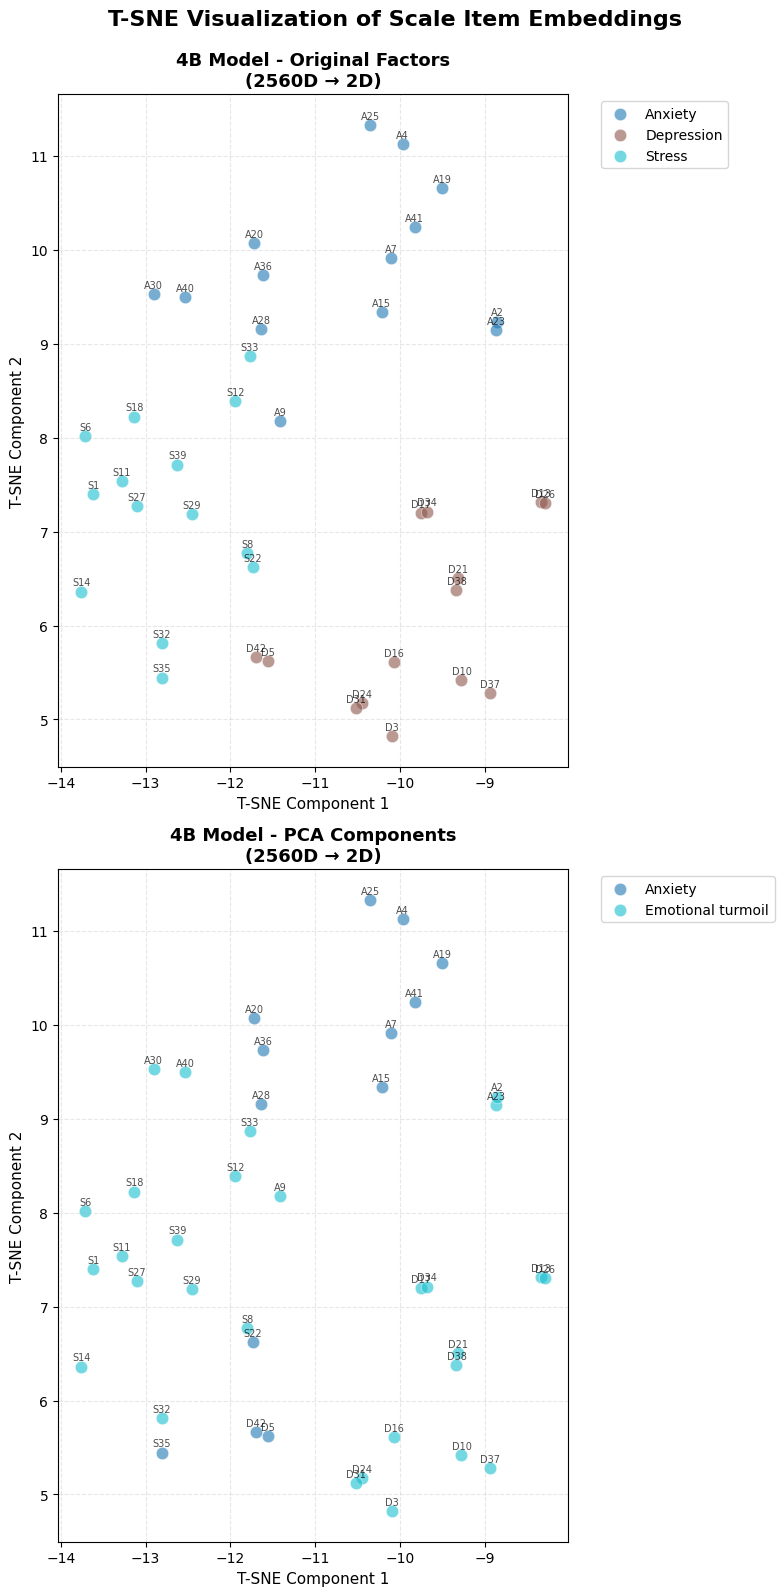


Creating individual plots...
  ✓ plots/qwen3_tsne_original_4B_20251023_233908.png


/tmp/ipykernel_2138426/3405318101.py:244: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  component_colors_map = plt.cm.get_cmap('tab10', n_components)


  ✓ plots/qwen3_tsne_pca_4B_20251023_233908.png

✓ Visualization complete!


In [62]:
# Create T-SNE scatter plots for all models
print("Creating T-SNE visualizations...")
print("=" * 70)

# Create plots directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)
print(f"Plots will be saved to: {plots_dir}/")

# Generate timestamp for filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Determine number of models
num_models = len(all_tsne_embeddings)
print(f"Creating plots for {num_models} model(s)...")

# Check if we have any models to plot
if num_models == 0:
    print("\n⚠ WARNING: No T-SNE embeddings available to plot!")
    print("  Please run the T-SNE computation cells first.")
    print("\nSkipping visualization...")
else:
    # Check if PCA component assignments are available
    pca_assignments_available = 'all_component_assignments' in dir() and len(all_component_assignments) > 0
    
    if not pca_assignments_available:
        print("\n⚠ WARNING: PCA component assignments not available!")
        print("  Please run the PCA analysis cell first.")
        print("  Will show original factor coloring only.\n")
    
    # Create main combined plot with 2 rows (if PCA assignments available)
    if pca_assignments_available:
        # 2 rows: top = original factors, bottom = PCA components
        fig_width = min(24, 8 * num_models)
        fig, axes = plt.subplots(2, min(3, num_models), figsize=(fig_width, 16))
        
        # Handle case of single model
        if min(3, num_models) == 1:
            axes = axes.reshape(2, 1)
    else:
        # Single row: original factors only
        fig_width = min(24, 8 * num_models)
        fig, axes = plt.subplots(1, min(3, num_models), figsize=(fig_width, 8))
        
        if min(3, num_models) == 1:
            axes = [axes]
    
    # Plot each model
    for idx, (model_size, embeddings_2d) in enumerate(sorted(all_tsne_embeddings.items())):
        if idx >= 3:  # Only plot first 3 models
            break
        
        # Get embedding dimension for titles
        embedding_dim = all_embeddings[model_size].shape[1]
        
        # ===== ROW 1: Original Factors =====
        if pca_assignments_available:
            ax = axes[0, idx]
        else:
            ax = axes[idx] if isinstance(axes, list) else axes
        
        # Plot each original factor with a different color
        for factor in unique_factors:
            indices = [i for i, f in enumerate(factors) if f == factor]
            ax.scatter(
                embeddings_2d[indices, 0],
                embeddings_2d[indices, 1],
                c=[factor_to_color[factor]],
                label=factor,
                alpha=0.6,
                s=80,
                edgecolors='white',
                linewidth=0.5
            )
        
        # Add labels
        for i in range(len(embeddings_2d)):
            ax.annotate(
                codes[i],
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=7,
                alpha=0.7,
                ha='center',
                va='bottom',
                xytext=(0, 3),
                textcoords='offset points'
            )
        
        ax.set_xlabel('T-SNE Component 1', fontsize=11)
        ax.set_ylabel('T-SNE Component 2', fontsize=11)
        ax.set_title(
            f'{model_size} Model - Original Factors\n({embedding_dim}D → 2D)',
            fontsize=13,
            fontweight='bold'
        )
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add legend to rightmost plot
        if idx == min(2, num_models - 1):
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        
        # ===== ROW 2: PCA Components =====
        if pca_assignments_available:
            ax = axes[1, idx]
            
            # Get component assignments for this model
            component_items = all_component_assignments[model_size]
            n_components = len(component_items)
            
            # Create color map for components
            component_colors_map = plt.cm.get_cmap('tab10', n_components)
            component_names = sorted(component_items.keys())
            component_to_color = {comp: component_colors_map(i) for i, comp in enumerate(component_names)}
            
            # Plot each component with a different color
            for comp_name in component_names:
                indices = [item['index'] for item in component_items[comp_name]]
                if len(indices) > 0:
                    ax.scatter(
                        embeddings_2d[indices, 0],
                        embeddings_2d[indices, 1],
                        c=[component_to_color[comp_name]],
                        label=comp_name,
                        alpha=0.6,
                        s=80,
                        edgecolors='white',
                        linewidth=0.5
                    )
            
            # Add labels
            for i in range(len(embeddings_2d)):
                ax.annotate(
                    codes[i],
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=7,
                    alpha=0.7,
                    ha='center',
                    va='bottom',
                    xytext=(0, 3),
                    textcoords='offset points'
                )
            
            ax.set_xlabel('T-SNE Component 1', fontsize=11)
            ax.set_ylabel('T-SNE Component 2', fontsize=11)
            ax.set_title(
                f'{model_size} Model - PCA Components\n({embedding_dim}D → 2D)',
                fontsize=13,
                fontweight='bold'
            )
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Add legend to rightmost plot
            if idx == min(2, num_models - 1):
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Overall title
    if pca_assignments_available:
        fig.suptitle(
            'T-SNE Visualization of Scale Item Embeddings',
            fontsize=16,
            fontweight='bold',
            y=0.995
        )
    else:
        fig.suptitle(
            'T-SNE Visualization of Scale Item Embeddings - Original Factors',
            fontsize=16,
            fontweight='bold',
            y=1.00
        )
    
    plt.tight_layout()
    
    # Save the combined figure
    model_names_str = "_".join(sorted(list(all_tsne_embeddings.keys())[:3]))
    if pca_assignments_available:
        filename = f"qwen3_tsne_combined_{model_names_str}_{timestamp}.png"
    else:
        filename = f"qwen3_tsne_original_{model_names_str}_{timestamp}.png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"\n✓ Combined plot saved to: {filepath}")
    
    # Display the plot
    plt.show()
    
    # ===== Save Individual Plots =====
    if pca_assignments_available:
        print(f"\nCreating individual plots...")
        
        for model_size, embeddings_2d in sorted(all_tsne_embeddings.items()):
            embedding_dim = all_embeddings[model_size].shape[1]
            
            # Individual plot 1: Original Factors
            fig, ax = plt.subplots(1, 1, figsize=(10, 8))
            
            for factor in unique_factors:
                indices = [i for i, f in enumerate(factors) if f == factor]
                ax.scatter(
                    embeddings_2d[indices, 0],
                    embeddings_2d[indices, 1],
                    c=[factor_to_color[factor]],
                    label=factor,
                    alpha=0.6,
                    s=80,
                    edgecolors='white',
                    linewidth=0.5
                )
            
            for i in range(len(embeddings_2d)):
                ax.annotate(
                    codes[i],
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=7,
                    alpha=0.7,
                    ha='center',
                    va='bottom',
                    xytext=(0, 3),
                    textcoords='offset points'
                )
            
            ax.set_xlabel('T-SNE Component 1', fontsize=11)
            ax.set_ylabel('T-SNE Component 2', fontsize=11)
            ax.set_title(
                f'{model_size} Model - Original Factors\n({embedding_dim}D → 2D)',
                fontsize=14,
                fontweight='bold'
            )
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.legend(loc='best', fontsize=10)
            
            plt.tight_layout()
            filename = f"qwen3_tsne_original_{model_size}_{timestamp}.png"
            filepath = os.path.join(plots_dir, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"  ✓ {filepath}")
            
            # Individual plot 2: PCA Components
            fig, ax = plt.subplots(1, 1, figsize=(10, 8))
            
            component_items = all_component_assignments[model_size]
            n_components = len(component_items)
            component_colors_map = plt.cm.get_cmap('tab10', n_components)
            component_names = sorted(component_items.keys())
            component_to_color = {comp: component_colors_map(i) for i, comp in enumerate(component_names)}
            
            for comp_name in component_names:
                indices = [item['index'] for item in component_items[comp_name]]
                if len(indices) > 0:
                    ax.scatter(
                        embeddings_2d[indices, 0],
                        embeddings_2d[indices, 1],
                        c=[component_to_color[comp_name]],
                        label=comp_name,
                        alpha=0.6,
                        s=80,
                        edgecolors='white',
                        linewidth=0.5
                    )
            
            for i in range(len(embeddings_2d)):
                ax.annotate(
                    codes[i],
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=7,
                    alpha=0.7,
                    ha='center',
                    va='bottom',
                    xytext=(0, 3),
                    textcoords='offset points'
                )
            
            ax.set_xlabel('T-SNE Component 1', fontsize=11)
            ax.set_ylabel('T-SNE Component 2', fontsize=11)
            ax.set_title(
                f'{model_size} Model - PCA Components\n({embedding_dim}D → 2D)',
                fontsize=14,
                fontweight='bold'
            )
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.legend(loc='best', fontsize=10)
            
            plt.tight_layout()
            filename = f"qwen3_tsne_pca_{model_size}_{timestamp}.png"
            filepath = os.path.join(plots_dir, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"  ✓ {filepath}")
    
    print("\n✓ Visualization complete!")